In [7]:
# @hidden_cells

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as geopd
import json


        
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
import matplotlib.colors as colors


d = 0.5 / np.sin(np.pi/3)  # radius of poylgon
o = 0.5 * np.tan(np.pi/3)  # orientation of polygon
y_diff = np.sqrt(1 - 0.5**2)  

def calc_coords(row, column):
    if row % 2 == 1:
        column = column + 0.5
    row = row * y_diff
    return row, column

def plotDFHex(df,value,ax=None,log=None):

    patches = []
    colours = []

    if ax==None:
        fig, ax = plt.subplots(1, figsize=(7, 7))
    #ax.axis("off")
    for i in range(df.shape[0]):

        y = df["r"][i]
        x = df["q"][i]
        y,x = calc_coords(y, x)
        if value==None:
            c=i
        else:
            c = df[value][i]

        #d=0.01
        #print (x,y,d)
        hexagon = RegularPolygon((x, y), numVertices=6, radius=d,
                             edgecolor='k',linewidth=0)

        #ax.add_patch(hexagon)
        #if i>2:break
        patches.append(hexagon)
        colours.append(c)
    #norm=colors.LogNorm(1,20000000),
    p = PatchCollection(patches, alpha=1.0,cmap=plt.get_cmap("viridis"))
    if log != None:
        zmin,zmax=log
        norm=colors.LogNorm(zmin,zmax) 
        p = PatchCollection(patches, alpha=1.0,cmap=plt.get_cmap("viridis"),norm=norm)
    p.set_array(np.array(colours))
    
    ax.add_collection(p)
    cbar=plt.colorbar(p,orientation='horizontal',pad=0.0,ax=ax)
    
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
   
    if value!=None:
        cbar.set_label(value)
    else:
        cbar.set_label('test')
    
    
    plt.show()
    

def plotMap(df,value,ax=None):
    if ax==None:
        fig,ax=plt.subplots(figsize=(7,7))
    df.plot(column=value,ax=ax,
          antialiased=False,
          legend=True,
          legend_kwds={'pad':0.05, 'label': value,
                       'orientation': "horizontal"}
          );
    ax.xaxis.tick_top()
    
    #actually turn them off now
    plt.axis('off')
    
    

def getMergedDF(_df,val,val_norm):
    df=_df[[val,val_norm]]
    df.loc[:,val]=df.loc[:,val]*df.loc[:,val_norm]

    df=df.groupby(level=0).sum()
    df[val]=df[val]/df[val_norm]
    return df


def make_map_plots(value):
    fig,ax=plt.subplots(1,2,figsize=(13,6.5))
   
    plotMap(imd_df_standard_map,value,ax=ax[0])
    plotDFHex(imd_df_hex_map,value,ax=ax[1])

#loading up of the hex data map
file = "../../data/UK.hexjson"
with open(file, "r", encoding="utf-8") as json_file:
      hex_data = json.load(json_file)
        
#make a dataframe out of it
hex_df = pd.DataFrame.from_dict(hex_data['hexes'],orient='index') 

#load up conversions between lsoas, wards and PCONS
lsoa_to_ward=pd.read_csv("../../data/LSOA_to_ward.csv")[['LSOA11CD','WD19CD','WD19NM']].set_index('WD19CD').drop_duplicates()
ward_to_PCON=pd.read_csv("../../data/Ward_to_Westminster_Parliamentary_Constituency_to_Local_Authority_District_to_Upper_Tier_Local_Authority_December_2019_Lookup_in_the_United_Kingdom.csv")
ward_to_PCON=ward_to_PCON.set_index('WD19CD')[['PCON19CD','PCON19NM']]
lsoa_to_PCON=ward_to_PCON.join(lsoa_to_ward).set_index('LSOA11CD').drop('WD19NM',axis=1)


#load up maps for the wards as well as for the LSOAs
map_wpc = geopd.read_file('../../topo_wpc.json')
map_lsoa=geopd.read_file('../../data/lsoa.geojson').set_index('LSOA11CD')


#load up the imd data
imd_data = pd.read_csv("../../data/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv") 
imd_data = imd_data.set_index("LSOA code (2011)")

#pick up the lsoa map
imd_df_standard_map=map_lsoa.merge(imd_data,left_index=True,right_index=True)



mdf = imd_data.join(lsoa_to_PCON)
mdf.index.name='LSOA'
mdf=mdf.reset_index()
mdf.set_index(['PCON19CD','LSOA'],inplace=True)



val_norm='Total population: mid 2015 (excluding prisoners)'
val='Index of Multiple Deprivation (IMD) Score'
temp_df = getMergedDF(mdf,val,val_norm)

imd_df_hex_map= temp_df.join(hex_df)




/Users/calummacdonald/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Mapping Data



In early May 2020 the [Office for National Statistics (ONS) published](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/deathsoccurringbetween1marchand17april) provisional datasets, summarising the number of deaths and age-standardised mortality rates involving the coronavirus (COVID-19). The data was collected between 1 March and 17 April 2020 in England and Wales. 

The ONS [analysed](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/deathsoccurringbetween1marchand17april#middle-layer-super-output-areas) the data per Middle Layer Super Output Areas (MSOAs) and linked this to [data](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019) based on deprivation in Lower Layer Super Output Areas (LSOAs). Their coding system is confusing, a short summary of some key codes (E=England, W=Wales, S=Scotland), that help group the data are as follows:

|Code|Description|Example|
|-----------|-----------|-----------|
|E00/W00/S00|Census Output Area (OA)| S6 1SA |
|E01/W01/S01|Lower layer Super Output Area (LSOA)| Sheffield 017C |
|E02/W02/S02|Middle layer Super Output Area (LSOA)| Sheffield 017 |
|E05/W05/S12|Ward or Electoral Division | Hillsborough |
|E14/W07/S14|Westminster Parliamentary Constituency| Sheffield, Brightside and Hillsborough | 


We will show you in this blog our analysis of the same datasets!

All plots and figures have been produced using the `python` package [pandas](https://pandas.pydata.org/docs/) for holding the data, [matplotlib](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html) for the graphics and [geopandas](https://geopandas.org/) for extra functionality in storing and plotting map data.

Boundary maps used in the blog were taken from the UK government [geoportal](http://geoportal.statistics.gov.uk/). [Open Data Institude (ODI) Leeds](https://odileeds.org/projects/hexmaps/constituencies/) provides a really great *hex* map of UK constituencies, making proportional data visualisation much easier.



## Index of Multiple Deprivation 





In [35]:
imd_sorted_table=mdf.reset_index()[['PCON19NM','LSOA name (2011)',
     'Index of Multiple Deprivation (IMD) Score',
     'Total population: mid 2015 (excluding prisoners)']].sort_values("Index of Multiple Deprivation (IMD) Score")


In [36]:
imd_sorted_table

PCON19NM           LSOA name (2011)  \
18657           Chesham and Amersham              Chiltern 005E   
28962    Harrogate and Knaresborough             Harrogate 021A   
33150                     Mid Sussex            Mid Sussex 008D   
17003                        Windsor      Bracknell Forest 002D   
19177           South Cambridgeshire  South Cambridgeshire 012B   
...                              ...                        ...   
13250                Blackpool South             Blackpool 013A   
13251                Blackpool South             Blackpool 013B   
13260  Blackpool North and Cleveleys             Blackpool 006A   
13252                Blackpool South             Blackpool 010A   
23158                        Clacton              Tendring 018A   

       Index of Multiple Deprivation (IMD) Score  \
18657                                      0.541   
28962                                      0.845   
33150                                      0.859   
17003                                      0.859   
19177                                      0.861   
...                                          ...   
13250                                     88.026   
13251                                     88.139   
13260                                     88.408   
13252                                     88.774   
23158                                     92.735   

       Total population: mid 2015 (excluding prisoners)  
18657                                              1624  
28962                                              1351  
33150                                              2002  
17003                                              1676  
19177                                              1587  
...                                                 ...  
13250                                              1420  
13251                                              1274  
13260                                              1511  
13252                                              1264  
23158                                              1950  

[35156 rows x 4 columns]

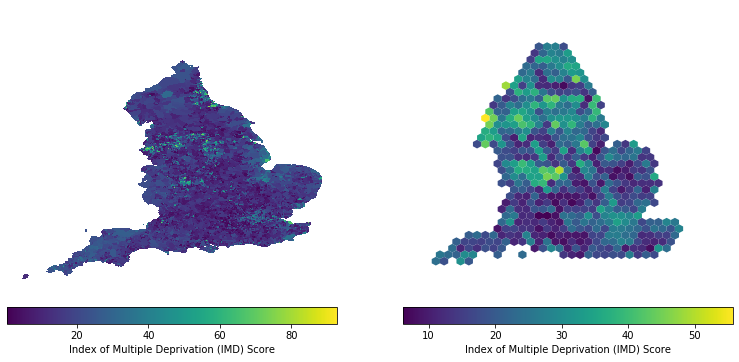

In [19]:
value='Index of Multiple Deprivation (IMD) Score'

fig,ax=plt.subplots(1,2,figsize=(13,6.5))
   

ax[0].axis('off')
ax[1].axis('off')

plotMap(imd_df_standard_map,value,ax=ax[0])
plotDFHex(imd_df_hex_map,value,ax=ax[1])


fig.savefig("_static/imd_map.png");


![](_static/imd_map.png)

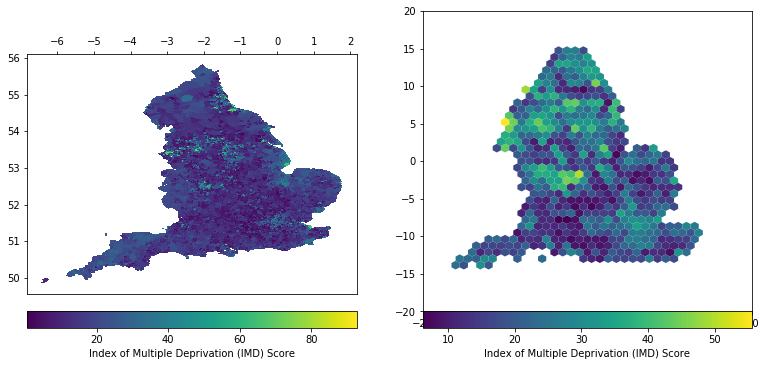

In [6]:
make_map_plots('Index of Multiple Deprivation (IMD) Score')

In [58]:
imd_df_hex_map.keys()
#imd_df_hex_map = imd_df_hex_map['']
#imd_df_hex_map['area']=geopd.GeoSeries(imd_df_hex_map['geometry']).area*1000.
#df2=df[['COVID-19','All causes','Total population: mid 2015 (excluding prisoners)','area']].groupby(level=0).sum().join(hex_df)

#df2['Population Density']=df2['Total population: mid 2015 (excluding prisoners)']/df2['area']


Index(['Index of Multiple Deprivation (IMD) Score',
       'Total population: mid 2015 (excluding prisoners)', 'n', 'q', 'r', 'a',
       'u', 'e', 'p'],
      dtype='object')

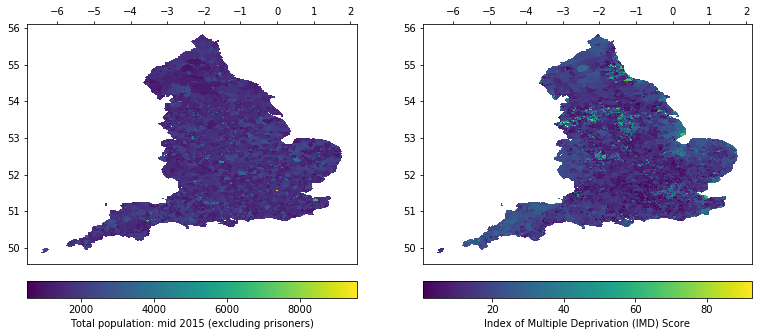

In [77]:
fig,ax=plt.subplots(1,2,figsize=(13,6.5))
plotMap(imd_df_standard_map,'Total population: mid 2015 (excluding prisoners)',ax=ax[0])
plotMap(imd_df_standard_map,'Index of Multiple Deprivation (IMD) Score',ax=ax[1])


#fg2=plotDFHex(imd_df_hex_map,'Index of Multiple Deprivation (IMD) Score',ax=ax[1])

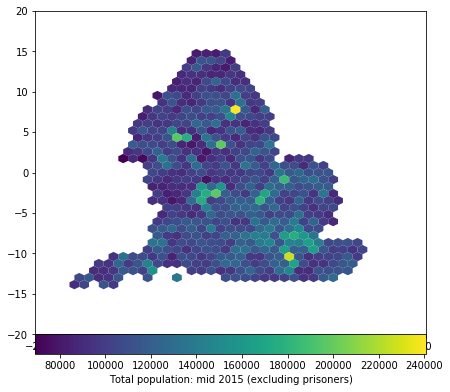

In [78]:
fg1=plotDFHex(imd_df_hex_map,'Total population: mid 2015 (excluding prisoners)')

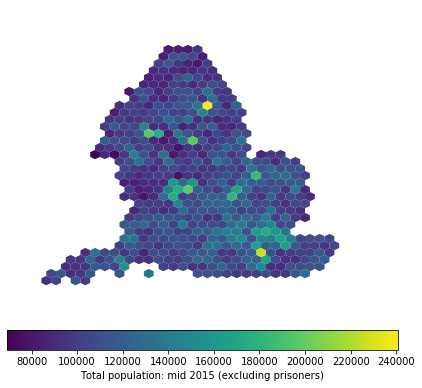

In [214]:
plotDF(frame,'Total population: mid 2015 (excluding prisoners)')

In [215]:
frame.sort_values('Total population: mid 2015 (excluding prisoners)')

Index of Multiple Deprivation (IMD) Score  \
PCON19CD                                               
E14001044                                  17.475150   
E14001043                                  17.035023   
E14000531                                  18.721940   
E14000664                                  11.840982   
E14000672                                  25.393970   
...                                              ...   
E14000807                                  41.519326   
E14000568                                  43.039664   
E14000919                                  19.205545   
E14000615                                  26.894498   
E14000777                                  36.578433   

           Total population: mid 2015 (excluding prisoners)  \
PCON19CD                                                      
E14001044                                             69290   
E14001043                                             73451   
E14000531                                             77644   
E14000664                                             78586   
E14000672                                             79723   
...                                                     ...   
E14000807                                            196425   
E14000568                                            196874   
E14000919                                            197920   
E14000615                                            226110   
E14000777                                            240687   

                                n   q   r   a    u      e       p  
PCON19CD                                                           
E14001044             Wirral West -11   2  NW  UKD  55377   69375  
E14001043            Wirral South  -9   2  NW  UKD  56956   72991  
E14000531     Aldridge-Brownhills  -3  -1  WM  UKG  60215   77532  
E14000664        Derbyshire Dales  -3   3  EM  UKF  63476   79872  
E14000672            Dudley South  -6  -4  WM  UKG  60363   81197  
...                           ...  ..  ..  ..  ...    ...     ...  
E14000807      Manchester Central  -6   5  NW  UKD  86078  158529  
E14000568     Birmingham, Yardley  -2  -3  WM  UKG  72146  113069  
E14000919       Sheffield Central  -1   4  YH  UKE  72321  130085  
E14000615  Camberwell and Peckham   6 -12  LO  UKI  82746  131739  
E14000777           Leeds Central   0   9  YH  UKE  81799  152847  

[533 rows x 9 columns]

### Deaths Per MSOA

In [216]:
import xlrd
workbook = xlrd.open_workbook("data/referencetablesdraft.xlsx")
deaths_by_authority_raw = workbook.sheet_by_index(7)

data = [deaths_by_authority_raw.row_values(rowx) for rowx in range(deaths_by_authority_raw.nrows)]
headers=data[11]
values=data[12:]

deaths_by_msoa = pd.DataFrame(values,columns = headers).set_index('MSOA code').drop("",axis=1)
deaths_by_msoa.sample(5)

MSOA name  All causes  COVID-19  \
MSOA code                                                 
E02001867          Birmingham 041        12.0       8.0   
E02006871           Lancaster 020        13.0       1.0   
E02003752             Fenland 011        10.0       0.0   
E02006579             Crawley 005        11.0       2.0   
E02004891  East Hertfordshire 014        15.0       3.0   

          COVID-19 deaths as a percentage of all causes (%)  
MSOA code                                                    
E02001867                                           66.6667  
E02006871                                           7.69231  
E02003752                                                 0  
E02006579                                           18.1818  
E02004891                                                20

look up mapper between LSOA and MSOA

In [217]:
lsoa_to_msoa=pd.read_csv("data/LSOA_to_MSOA.csv")[['LSOA11CD','MSOA11CD']].drop_duplicates() 
lsoa_to_msoa.sample(5)

LSOA11CD   MSOA11CD
106706  E01032321  E02006742
176387  S01009216  S02001729
205068  S01013450  S02002509
86106   E01027935  E02005831
32809   E01028969  E02006028

In [218]:
df=mdf.reset_index()
df=df.join(lsoa_to_msoa.set_index('LSOA11CD'),on=['LSOA'])
#df=df.set_index(['PCON19CD','MSOA11CD','LSOA'])
df

PCON19CD       LSOA           LSOA name (2011)  \
0      E14000639  E01000001        City of London 001A   
1      E14000639  E01000002        City of London 001B   
2      E14000639  E01000003        City of London 001C   
3      E14000639  E01000005        City of London 001E   
4      E14000540  E01000006  Barking and Dagenham 016A   
...          ...        ...                        ...   
35151  E14000794  E01033764             Liverpool 022E   
35152  E14000793  E01033765             Liverpool 061D   
35153  E14000793  E01033766             Liverpool 042G   
35154  E14000793  E01033767             Liverpool 050J   
35155  E14000793  E01033768             Liverpool 037F   

      Local Authority District code (2019)  \
0                                E09000001   
1                                E09000001   
2                                E09000001   
3                                E09000001   
4                                E09000002   
...                                    ...   
35151                            E08000012   
35152                            E08000012   
35153                            E08000012   
35154                            E08000012   
35155                            E08000012   

      Local Authority District name (2019)  \
0                           City of London   
1                           City of London   
2                           City of London   
3                           City of London   
4                     Barking and Dagenham   
...                                    ...   
35151                            Liverpool   
35152                            Liverpool   
35153                            Liverpool   
35154                            Liverpool   
35155                            Liverpool   

       Index of Multiple Deprivation (IMD) Score  \
0                                          6.208   
1                                          5.143   
2                                         19.402   
3                                         28.652   
4                                         19.837   
...                                          ...   
35151                                     74.468   
35152                                     59.599   
35153                                     21.895   
35154                                     66.704   
35155                                     52.286   

       Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
0                                                  29199                     
1                                                  30379                     
2                                                  14915                     
3                                                   8678                     
4                                                  14486                     
...                                                  ...                     
35151                                                116                     
35152                                                945                     
35153                                              12842                     
35154                                                422                     
35155                                               1833                     

       Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)  \
0                                                      9                                    
1                                                     10                                    
2                                                      5                                    
3                                                      3                                    
4                                                      5                                    
...                                                  ...                             

In [219]:
df=df.merge(deaths_by_msoa,left_on='MSOA11CD',right_on='MSOA code').set_index(['PCON19CD','MSOA11CD','LSOA'])
df

LSOA name (2011)  \
PCON19CD  MSOA11CD  LSOA                             
E14000639 E02000001 E01000001  City of London 001A   
                    E01000002  City of London 001B   
                    E01000003  City of London 001C   
                    E01000005  City of London 001E   
                    E01032739  City of London 001F   
...                                            ...   
E14000793 E02006933 E01033765       Liverpool 061D   
          E02006934 E01033751       Liverpool 062A   
                    E01033752       Liverpool 062B   
                    E01033753       Liverpool 062C   
                    E01033755       Liverpool 062D   

                              Local Authority District code (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                            E09000001   
                    E01000002                            E09000001   
                    E01000003                            E09000001   
                    E01000005                            E09000001   
                    E01032739                            E09000001   
...                                                            ...   
E14000793 E02006933 E01033765                            E08000012   
          E02006934 E01033751                            E08000012   
                    E01033752                            E08000012   
                    E01033753                            E08000012   
                    E01033755                            E08000012   

                              Local Authority District name (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                       City of London   
                    E01000002                       City of London   
                    E01000003                       City of London   
                    E01000005                       City of London   
                    E01032739                       City of London   
...                                                            ...   
E14000793 E02006933 E01033765                            Liverpool   
          E02006934 E01033751                            Liverpool   
                    E01033752                            Liverpool   
                    E01033753                            Liverpool   
                    E01033755                            Liverpool   

                               Index of Multiple Deprivation (IMD) Score  \
PCON19CD  MSOA11CD  LSOA                                                   
E14000639 E02000001 E01000001                                      6.208   
                    E01000002                                      5.143   
                    E01000003                                     19.402   
                    E01000005                                     28.652   
                    E01032739                                     13.584   
...                                                                  ...   
E14000793 E02006933 E01033765                                     59.599   
          E02006934 E01033751                                     41.135   
                    E01033752                                      8.974   
                    E01033753                                     10.020   
                    E01033755                                     17.515   

                               Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
PCON19CD  MSOA11CD  LSOA                                                                             
E14000639 E02000001 E01000001                                              29199                     
                    E01000002                                              30379                     
                    E01000003                                              14915                     
          

In [220]:
cols=deaths_by_msoa.columns
dup=df.duplicated(cols)
df.loc[dup,cols]=np.NaN
df

LSOA name (2011)  \
PCON19CD  MSOA11CD  LSOA                             
E14000639 E02000001 E01000001  City of London 001A   
                    E01000002  City of London 001B   
                    E01000003  City of London 001C   
                    E01000005  City of London 001E   
                    E01032739  City of London 001F   
...                                            ...   
E14000793 E02006933 E01033765       Liverpool 061D   
          E02006934 E01033751       Liverpool 062A   
                    E01033752       Liverpool 062B   
                    E01033753       Liverpool 062C   
                    E01033755       Liverpool 062D   

                              Local Authority District code (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                            E09000001   
                    E01000002                            E09000001   
                    E01000003                            E09000001   
                    E01000005                            E09000001   
                    E01032739                            E09000001   
...                                                            ...   
E14000793 E02006933 E01033765                            E08000012   
          E02006934 E01033751                            E08000012   
                    E01033752                            E08000012   
                    E01033753                            E08000012   
                    E01033755                            E08000012   

                              Local Authority District name (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                       City of London   
                    E01000002                       City of London   
                    E01000003                       City of London   
                    E01000005                       City of London   
                    E01032739                       City of London   
...                                                            ...   
E14000793 E02006933 E01033765                            Liverpool   
          E02006934 E01033751                            Liverpool   
                    E01033752                            Liverpool   
                    E01033753                            Liverpool   
                    E01033755                            Liverpool   

                               Index of Multiple Deprivation (IMD) Score  \
PCON19CD  MSOA11CD  LSOA                                                   
E14000639 E02000001 E01000001                                      6.208   
                    E01000002                                      5.143   
                    E01000003                                     19.402   
                    E01000005                                     28.652   
                    E01032739                                     13.584   
...                                                                  ...   
E14000793 E02006933 E01033765                                     59.599   
          E02006934 E01033751                                     41.135   
                    E01033752                                      8.974   
                    E01033753                                     10.020   
                    E01033755                                     17.515   

                               Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
PCON19CD  MSOA11CD  LSOA                                                                             
E14000639 E02000001 E01000001                                              29199                     
                    E01000002                                              30379                     
                    E01000003                                              14915                     
          

In [242]:
df2=df[['COVID-19','All causes','Total population: mid 2015 (excluding prisoners)']].groupby(level=0).sum().join(hex_df)
df2.sort_values('COVID-19')

COVID-19  All causes  \
PCON19CD                          
E14000780       0.0         0.0   
E14000815       1.0        40.0   
E14000864       2.0       135.0   
E14000837       4.0       129.0   
E14000707       4.0       152.0   
...             ...         ...   
E14000679     117.0       219.0   
E14000591     123.0       213.0   
E14000731     130.0       258.0   
E14000655     132.0       262.0   
E14000592     151.0       271.0   

           Total population: mid 2015 (excluding prisoners)  \
PCON19CD                                                      
E14000780                                             95755   
E14000815                                             96789   
E14000864                                            110736   
E14000837                                             91258   
E14000707                                             95518   
...                                                     ...   
E14000679                                            160162   
E14000591                                            143605   
E14000731                                            107439   
E14000655                                            169437   
E14000592                                            134853   

                                    n   q   r   a    u      e       p  
PCON19CD                                                               
E14000780            Leeds North West   0  10  YH  UKE  61974   86016  
E14000815  Mid Dorset and North Poole  -8 -12  SW  UKK  64299   82737  
E14000864               Norwich South   8   0  EA  UKH  74875  103284  
E14000837              North Cornwall -14 -14  SW  UKK  67192   92772  
E14000707                Gainsborough   2   5  EM  UKF  74686   96951  
...                               ...  ..  ..  ..  ...    ...     ...  
E14000679                    East Ham   7  -9  LO  UKI  87382  162796  
E14000591               Brent Central   2  -9  LO  UKI  77038  147291  
E14000731                 Harrow East   2  -8  LO  UKI  70981  108089  
E14000655               Croydon North   6 -13  LO  UKI  85941  146065  
E14000592                 Brent North   1  -9  LO  UKI  82196  136376  

[533 rows x 10 columns]

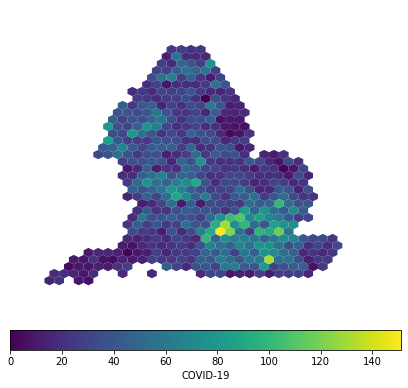

In [225]:
plotDF(df2,'COVID-19')

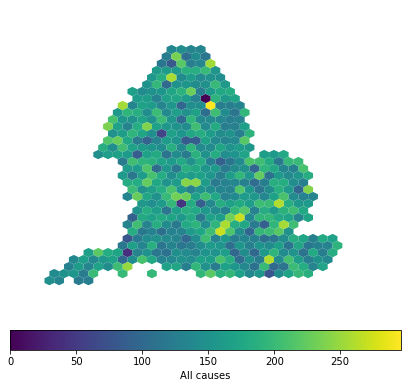

In [227]:
plotDF(df2,'All causes')

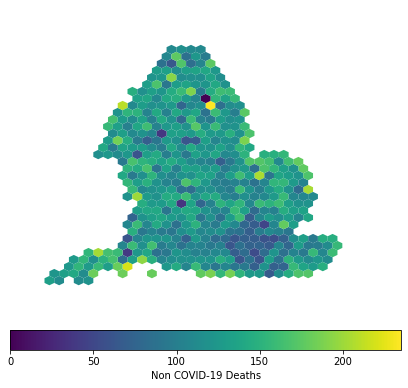

In [229]:
df2['Non COVID-19 Deaths']=df2['All causes'] - df2['COVID-19']
plotDF(df2,'Non COVID-19 Deaths')

In [237]:
df[df['All causes']>0]

LSOA name (2011)  \
PCON19CD  MSOA11CD  LSOA                                   
E14000639 E02000001 E01000001        City of London 001A   
E14000540 E02000017 E01000006  Barking and Dagenham 016A   
          E02000016 E01000007  Barking and Dagenham 015A   
          E02000014 E01000013  Barking and Dagenham 013A   
          E02000010 E01000015  Barking and Dagenham 009A   
...                                                  ...   
E14000602 E02006887 E01033352               Bristol 054A   
E14000864 E02006907 E01033438               Norwich 014A   
E14000564 E02006899 E01033620            Birmingham 138A   
E14000793 E02006933 E01033750             Liverpool 061A   
          E02006934 E01033751             Liverpool 062A   

                              Local Authority District code (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                            E09000001   
E14000540 E02000017 E01000006                            E09000002   
          E02000016 E01000007                            E09000002   
          E02000014 E01000013                            E09000002   
          E02000010 E01000015                            E09000002   
...                                                            ...   
E14000602 E02006887 E01033352                            E06000023   
E14000864 E02006907 E01033438                            E07000148   
E14000564 E02006899 E01033620                            E08000025   
E14000793 E02006933 E01033750                            E08000012   
          E02006934 E01033751                            E08000012   

                              Local Authority District name (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                       City of London   
E14000540 E02000017 E01000006                 Barking and Dagenham   
          E02000016 E01000007                 Barking and Dagenham   
          E02000014 E01000013                 Barking and Dagenham   
          E02000010 E01000015                 Barking and Dagenham   
...                                                            ...   
E14000602 E02006887 E01033352                     Bristol, City of   
E14000864 E02006907 E01033438                              Norwich   
E14000564 E02006899 E01033620                           Birmingham   
E14000793 E02006933 E01033750                            Liverpool   
          E02006934 E01033751                            Liverpool   

                               Index of Multiple Deprivation (IMD) Score  \
PCON19CD  MSOA11CD  LSOA                                                   
E14000639 E02000001 E01000001                                      6.208   
E14000540 E02000017 E01000006                                     19.837   
          E02000016 E01000007                                     31.576   
          E02000014 E01000013                                     38.997   
          E02000010 E01000015                                     33.632   
...                                                                  ...   
E14000602 E02006887 E01033352                                     30.137   
E14000864 E02006907 E01033438                                     22.971   
E14000564 E02006899 E01033620                                     27.122   
E14000793 E02006933 E01033750                                     11.769   
          E02006934 E01033751                                     41.135   

                               Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
PCON19CD  MSOA11CD  LSOA                                                                             
E14000639 E02000001 E01000001                                              29199                     
E14000540 E02000017 E01000006                                              14486                     
          E02000016 E01000007           

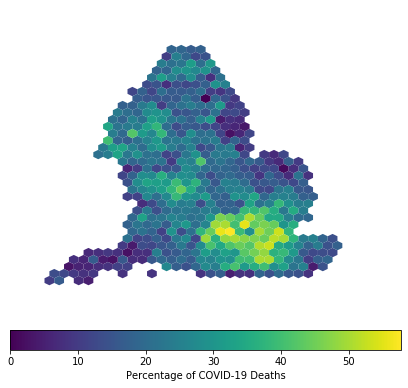

In [249]:
df2['Percentage of Deaths from COVID-19']=df2.apply(lambda x: 100.*x['COVID-19']/x['All causes'] if x['All causes']>0 else 0, axis=1)
plotDF(df2,'Percentage of COVID-19 Deaths')

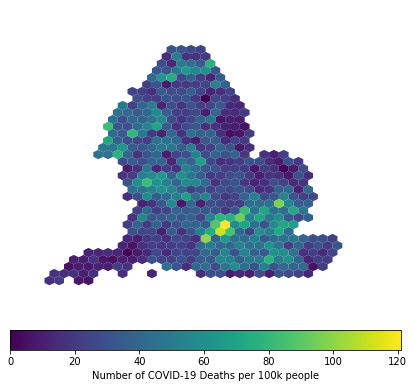

In [250]:
df2['Number of COVID-19 Deaths per 100k people']=100000*df2['COVID-19']/df2['Total population: mid 2015 (excluding prisoners)']
plotDF(df2,'Number of COVID-19 Deaths per 100k people')

In [255]:
df2.sort_values('Number of COVID-19 Deaths per 100k people')[['n','COVID-19','All causes','Total population: mid 2015 (excluding prisoners)','Number of COVID-19 Deaths per 100k people']]



n  COVID-19  All causes  \
PCON19CD                                                      
E14000780            Leeds North West       0.0         0.0   
E14000815  Mid Dorset and North Poole       1.0        40.0   
E14000864               Norwich South       2.0       135.0   
E14000707                Gainsborough       4.0       152.0   
E14000988               Taunton Deane       5.0       171.0   
...                               ...       ...         ...   
E14000636             Chipping Barnet     110.0       271.0   
E14000745                   Hertsmere     100.0       261.0   
E14000676            Ealing, Southall     100.0       204.0   
E14000592                 Brent North     151.0       271.0   
E14000731                 Harrow East     130.0       258.0   

           Total population: mid 2015 (excluding prisoners)  \
PCON19CD                                                      
E14000780                                             95755   
E14000815                                             96789   
E14000864                                            110736   
E14000707                                             95518   
E14000988                                            114241   
...                                                     ...   
E14000636                                            117033   
E14000745                                            103157   
E14000676                                             99531   
E14000592                                            134853   
E14000731                                            107439   

           Number of COVID-19 Deaths per 100k people  
PCON19CD                                              
E14000780                                   0.000000  
E14000815                                   1.033175  
E14000864                                   1.806097  
E14000707                                   4.187692  
E14000988                                   4.376712  
...                                              ...  
E14000636                                  93.990584  
E14000745                                  96.939616  
E14000676                                 100.471210  
E14000592                                 111.973779  
E14000731                                 120.998892  

[533 rows x 5 columns]

## Actual map

In [257]:
import geopandas as geopd

In [259]:
lsoa_map=geopd.read_file('data/lsoa.geojson').set_index('LSOA11CD')

In [260]:
lsoa_map

LSOA11NM                  LSOA11NMW  \
LSOA11CD                                                          
E01000001        City of London 001A        City of London 001A   
E01000002        City of London 001B        City of London 001B   
E01000003        City of London 001C        City of London 001C   
E01000005        City of London 001E        City of London 001E   
E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...                              ...                        ...   
W01001954               Cardiff 006F              Caerdydd 006F   
W01001955               Swansea 025F              Abertawe 025F   
W01001956               Swansea 023E              Abertawe 023E   
W01001957               Swansea 025G              Abertawe 025G   
W01001958               Swansea 025H              Abertawe 025H   

                                                    geometry  
LSOA11CD                                                      
E01000001  POLYGON ((-0.09729 51.52158, -0.09652 51.52027...  
E01000002  POLYGON ((-0.08813 51.51941, -0.08929 51.51752...  
E01000003  POLYGON ((-0.09679 51.52325, -0.09647 51.52282...  
E01000005  POLYGON ((-0.07323 51.51000, -0.07553 51.50974...  
E01000006  POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...  
...                                                      ...  
W01001954  POLYGON ((-3.25545 51.52101, -3.25488 51.51968...  
W01001955  POLYGON ((-3.94052 51.63059, -3.93912 51.62701...  
W01001956  POLYGON ((-4.02463 51.63614, -4.02456 51.63573...  
W01001957  POLYGON ((-3.94918 51.61754, -3.94812 51.61669...  
W01001958  POLYGON ((-3.93504 51.62182, -3.93144 51.61738...  

[34753 rows x 3 columns]

In [267]:
df=mdf.reset_index()
df=df.merge(lsoa_map,left_on='LSOA',right_on='LSOA11CD')
df=df.merge(lsoa_to_msoa,left_on='LSOA',right_on='LSOA11CD')
df=df.merge(deaths_by_msoa,left_on='MSOA11CD',right_on='MSOA code').set_index(['PCON19CD','MSOA11CD','LSOA'])

cols=deaths_by_msoa.columns
dup=df.duplicated(cols)
df.loc[dup,cols]=np.NaN


df




LSOA name (2011)  \
PCON19CD  MSOA11CD  LSOA                             
E14000639 E02000001 E01000001  City of London 001A   
                    E01000002  City of London 001B   
                    E01000003  City of London 001C   
                    E01000005  City of London 001E   
                    E01032739  City of London 001F   
...                                            ...   
E14000793 E02006933 E01033765       Liverpool 061D   
          E02006934 E01033751       Liverpool 062A   
                    E01033752       Liverpool 062B   
                    E01033753       Liverpool 062C   
                    E01033755       Liverpool 062D   

                              Local Authority District code (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                            E09000001   
                    E01000002                            E09000001   
                    E01000003                            E09000001   
                    E01000005                            E09000001   
                    E01032739                            E09000001   
...                                                            ...   
E14000793 E02006933 E01033765                            E08000012   
          E02006934 E01033751                            E08000012   
                    E01033752                            E08000012   
                    E01033753                            E08000012   
                    E01033755                            E08000012   

                              Local Authority District name (2019)  \
PCON19CD  MSOA11CD  LSOA                                             
E14000639 E02000001 E01000001                       City of London   
                    E01000002                       City of London   
                    E01000003                       City of London   
                    E01000005                       City of London   
                    E01032739                       City of London   
...                                                            ...   
E14000793 E02006933 E01033765                            Liverpool   
          E02006934 E01033751                            Liverpool   
                    E01033752                            Liverpool   
                    E01033753                            Liverpool   
                    E01033755                            Liverpool   

                               Index of Multiple Deprivation (IMD) Score  \
PCON19CD  MSOA11CD  LSOA                                                   
E14000639 E02000001 E01000001                                      6.208   
                    E01000002                                      5.143   
                    E01000003                                     19.402   
                    E01000005                                     28.652   
                    E01032739                                     13.584   
...                                                                  ...   
E14000793 E02006933 E01033765                                     59.599   
          E02006934 E01033751                                     41.135   
                    E01033752                                      8.974   
                    E01033753                                     10.020   
                    E01033755                                     17.515   

                               Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
PCON19CD  MSOA11CD  LSOA                                                                             
E14000639 E02000001 E01000001                                              29199                     
                    E01000002                                              30379                     
                    E01000003                                              14915                     
          

In [322]:
df['area']=geopd.GeoSeries(df['geometry']).area*1000.
df2=df[['COVID-19','All causes','Total population: mid 2015 (excluding prisoners)','area']].groupby(level=0).sum().join(hex_df)

df2['Population Density']=df2['Total population: mid 2015 (excluding prisoners)']/df2['area']

df2.sort_values('COVID-19')

COVID-19  All causes  \
PCON19CD                          
E14000780       0.0         0.0   
E14000815       1.0        40.0   
E14000864       2.0       135.0   
E14000837       4.0       129.0   
E14000707       4.0       152.0   
...             ...         ...   
E14000679     117.0       219.0   
E14000591     123.0       213.0   
E14000731     130.0       258.0   
E14000655     132.0       262.0   
E14000592     151.0       271.0   

           Total population: mid 2015 (excluding prisoners)        area  \
PCON19CD                                                                  
E14000780                                             95755    8.636409   
E14000815                                             96789   47.177064   
E14000864                                            110736    4.124386   
E14000837                                             91258  151.834263   
E14000707                                             95518  162.284909   
...                                                     ...         ...   
E14000679                                            160162    2.447466   
E14000591                                            143605    2.370776   
E14000731                                            107439    3.078863   
E14000655                                            169437    2.787729   
E14000592                                            134853    2.695732   

                                    n   q   r   a    u      e       p  \
PCON19CD                                                                
E14000780            Leeds North West   0  10  YH  UKE  61974   86016   
E14000815  Mid Dorset and North Poole  -8 -12  SW  UKK  64299   82737   
E14000864               Norwich South   8   0  EA  UKH  74875  103284   
E14000837              North Cornwall -14 -14  SW  UKK  67192   92772   
E14000707                Gainsborough   2   5  EM  UKF  74686   96951   
...                               ...  ..  ..  ..  ...    ...     ...   
E14000679                    East Ham   7  -9  LO  UKI  87382  162796   
E14000591               Brent Central   2  -9  LO  UKI  77038  147291   
E14000731                 Harrow East   2  -8  LO  UKI  70981  108089   
E14000655               Croydon North   6 -13  LO  UKI  85941  146065   
E14000592                 Brent North   1  -9  LO  UKI  82196  136376   

           Population Density  
PCON19CD                       
E14000780        11087.362825  
E14000815         2051.611331  
E14000864        26849.085214  
E14000837          601.036936  
E14000707          588.582146  
...                       ...  
E14000679        65439.920417  
E14000591        60572.987384  
E14000731        34895.670790  
E14000655        60779.581505  
E14000592        50024.637115  

[533 rows x 12 columns]

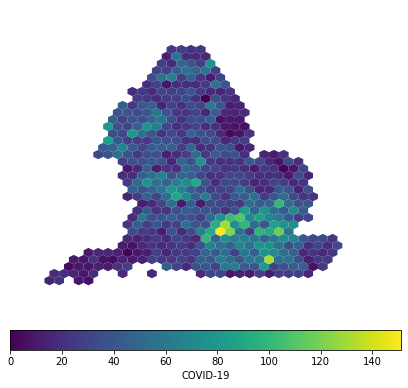

In [329]:
plotDF(df2,'COVID-19')

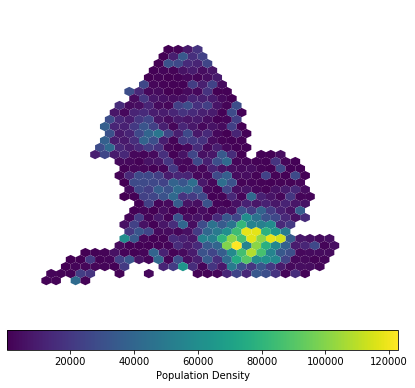

In [330]:
plotDF(df2,'Population Density')

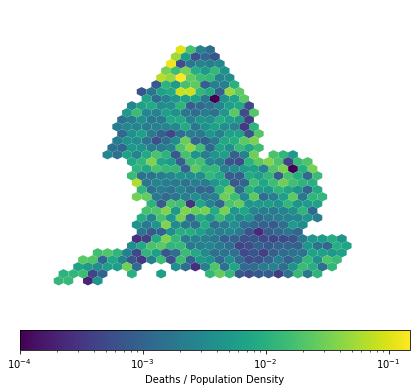

In [324]:
df2['Deaths / Population Density']=df2.apply(lambda x: x['COVID-19']/x['Population Density'] if x['Population Density']>0 and x['COVID-19']>0 else 0.0001,axis=1)
plotDF(df2,'Deaths / Population Density',log=(0.0001,df2['Deaths / Population Density'].max()))



In [327]:
df2.sort_values('Population Density')

COVID-19  All causes  \
PCON19CD                          
E14000877      28.0       116.0   
E14000554      25.0       136.0   
E14000746      13.0       122.0   
E14000993      16.0       178.0   
E14000928      29.0       174.0   
...             ...         ...   
E14000764      60.0       129.0   
E14000720      98.0       196.0   
E14000555      60.0       116.0   
E14000763      28.0        98.0   
E14001036      69.0       155.0   

           Total population: mid 2015 (excluding prisoners)        area  \
PCON19CD                                                                  
E14000877                                            100459  454.317952   
E14000554                                             81471  343.497907   
E14000746                                             85763  345.977758   
E14000993                                            101067  303.724351   
E14000928                                            102524  294.926344   
...                                                     ...         ...   
E14000764                                            113944    0.970742   
E14000720                                            164298    1.398097   
E14000555                                            144056    1.223956   
E14000763                                            112792    0.955616   
E14001036                                            126805    1.033021   

                                           n  q   r   a    u      e       p  \
PCON19CD                                                                      
E14000877             Penrith and The Border -5  15  NW  UKD  65209   82409   
E14000554                 Berwick-upon-Tweed -4  17  NE  UKC  56969   75542   
E14000746                             Hexham -4  16  NE  UKC  59708   77272   
E14000993                  Thirsk and Malton  1  11  YH  UKE  77451  100911   
E14000928                  Skipton and Ripon -4  11  YH  UKE  76645   99840   
...                                      ... ..  ..  ..  ...    ...     ...   
E14000764       Islington South and Finsbury  5 -10  LO  UKI  68127  118926   
E14000720  Hackney North and Stoke Newington  5  -9  LO  UKI  88153  141379   
E14000555              Bethnal Green and Bow  7 -10  LO  UKI  82727  146820   
E14000763                    Islington North  4  -9  LO  UKI  73326  116074   
E14001036                  Westminster North  3 -11  LO  UKI  62346  129527   

           Population Density  Deaths / Population Density  
PCON19CD                                                    
E14000877          221.120472                     0.126628  
E14000554          237.180485                     0.105405  
E14000746          247.885877                     0.052443  
E14000993          332.758963                     0.048083  
E14000928          347.625778                     0.083423  
...                       ...                          ...  
E14000764       117378.230503                     0.000511  
E14000720       117515.423447                     0.000834  
E14000555       117697.030225                     0.000510  
E14000763       118030.636070                     0.000237  
E14001036       122751.613622                     0.000562  

[533 rows x 13 columns]

In [328]:
df2.sort_values('Deaths / Population Density').drop(['q','r','a','u','e','p'],axis=1)

COVID-19  All causes  \
PCON19CD                          
E14000864       2.0       135.0   
E14000780       0.0         0.0   
E14000880       9.0       122.0   
E14000763      28.0        98.0   
E14000884      18.0       125.0   
...             ...         ...   
E14000928      29.0       174.0   
E14000895      31.0       190.0   
E14000554      25.0       136.0   
E14000877      28.0       116.0   
E14001037      64.0       257.0   

           Total population: mid 2015 (excluding prisoners)        area  \
PCON19CD                                                                  
E14000864                                            110736    4.124386   
E14000780                                             95755    8.636409   
E14000880                                            113075    2.668777   
E14000763                                            112792    0.955616   
E14000884                                            110844    1.715006   
...                                                     ...         ...   
E14000928                                            102524  294.926344   
E14000895                                            111709  305.843241   
E14000554                                             81471  343.497907   
E14000877                                            100459  454.317952   
E14001037                                             86177  201.420477   

                                        n  Population Density  \
PCON19CD                                                        
E14000864                   Norwich South        26849.085214   
E14000780                Leeds North West        11087.362825   
E14000880  Plymouth, Sutton and Devonport        42369.598408   
E14000763                 Islington North       118030.636070   
E14000884                Portsmouth South        64631.855645   
...                                   ...                 ...   
E14000928               Skipton and Ripon          347.625778   
E14000895                Richmond (Yorks)          365.249203   
E14000554              Berwick-upon-Tweed          237.180485   
E14000877          Penrith and The Border          221.120472   
E14001037        Westmorland and Lonsdale          427.846270   

           Deaths / Population Density  
PCON19CD                                
E14000864                     0.000074  
E14000780                     0.000100  
E14000880                     0.000212  
E14000763                     0.000237  
E14000884                     0.000279  
...                                ...  
E14000928                     0.083423  
E14000895                     0.084874  
E14000554                     0.105405  
E14000877                     0.126628  
E14001037                     0.149586  

[533 rows x 7 columns]

In [348]:
workbook = xlrd.open_workbook("data/Ethnic-group.xlsx")
census_raw= workbook.sheet_by_index(2)

data = [census_raw.row_values(rowx) for rowx in range(census_raw.nrows)]
headers=data[0]
values=data[1:]



ethnicity = pd.DataFrame(values,columns = headers).set_index('ONSConstID')
ethnicity.head(5)

ConstituencyName   RegionID  RegionName  CountryID  \
ONSConstID                                                         
E14000554   Berwick-upon-Tweed  E12000001  North East  K02000001   
E14000569      Bishop Auckland  E12000001  North East  K02000002   
E14000574              Blaydon  E12000001  North East  K02000003   
E14000575         Blyth Valley  E12000001  North East  K02000004   
E14000641       City of Durham  E12000001  North East  K02000005   

               CountryName  DateThisUpdate  DateOfDataset  PopTotalConstNum  \
ONSConstID                                                                    
E14000554   United Kingdom         43228.0         2011.0           75718.0   
E14000569   United Kingdom         43228.0         2011.0           87143.0   
E14000574   United Kingdom         43228.0         2011.0           88281.0   
E14000575   United Kingdom         43228.0         2011.0           82174.0   
E14000641   United Kingdom         43228.0         2011.0           94375.0   

            PopWhiteConstNum  PopMixedConstNum  ...  PopMixedUKNum  \
ONSConstID                                      ...                  
E14000554            74698.0             373.0  ...      1250229.0   
E14000569            86058.0             461.0  ...      1250229.0   
E14000574            86692.0             504.0  ...      1250229.0   
E14000575            81071.0             442.0  ...      1250229.0   
E14000641            90135.0             994.0  ...      1250229.0   

            PopAsianUKNum  PopBlackUKNum  PopOtherUKNum  PopTotalUK%  \
ONSConstID                                                             
E14000554       4373339.0      1904684.0       580374.0          1.0   
E14000569       4373339.0      1904684.0       580374.0          1.0   
E14000574       4373339.0      1904684.0       580374.0          1.0   
E14000575       4373339.0      1904684.0       580374.0          1.0   
E14000641       4373339.0      1904684.0       580374.0          1.0   

            PopWhiteUK%  PopMixedUK%  PopAsianUK%  PopBlackUK%  PopOtherUK%  
ONSConstID                                                                   
E14000554      0.871663     0.019788     0.069218     0.030146     0.009186  
E14000569      0.871663     0.019788     0.069218     0.030146     0.009186  
E14000574      0.871663     0.019788     0.069218     0.030146     0.009186  
E14000575      0.871663     0.019788     0.069218     0.030146     0.009186  
E14000641      0.871663     0.019788     0.069218     0.030146     0.009186  

[5 rows x 43 columns]

In [350]:
df3=df2.join(ethnicity)

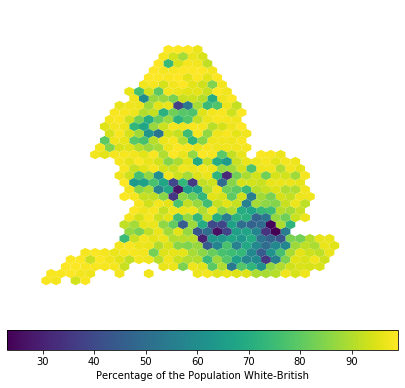

In [351]:
df3['Percentage of the Population White-British'] = 100*df3['PopWhiteConstNum'] / df3['PopTotalConstNum']
plotDF(df3,'Percentage of the Population White-British')

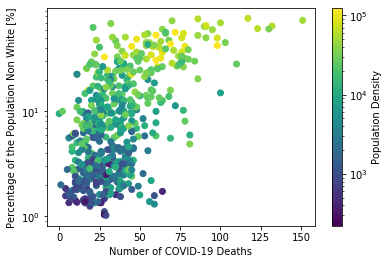

In [368]:
#df3['test']=df3['COVID-19'] / df3['Percentage of the Population White-British']
#plotDF(df3,'test')

df3['Percentage of the Population Non White']=100-df3['Percentage of the Population White-British']


zmin=df3['Population Density'].min()
zmax=df3['Population Density'].max()

fig,ax=plt.subplots(1)
sc=ax.scatter(df3['COVID-19'],df3['Percentage of the Population Non White'],
               c=df3['Population Density'],
               norm=colors.LogNorm(zmin,zmax),
               label='Parliamentary Constituencies')

cbar=plt.colorbar(sc)
cbar.set_label("Population Density")

ax.set_ylabel("Percentage of the Population Non White [%]")
ax.set_xlabel("Number of COVID-19 Deaths")
ax.set_yscale('log')
#ax.set_scale('log')


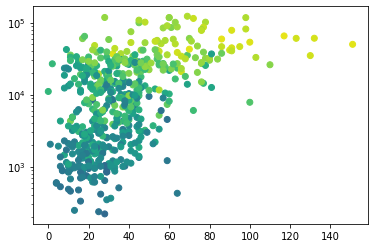

In [370]:
fig,ax=plt.subplots(1)
sc=ax.scatter(df3['COVID-19'],df3['Population Density'],
               c=df3['Percentage of the Population Non White'],
               norm=colors.LogNorm(0.1,100),
               label='Parliamentary Constituencies')
ax.set_yscale('log')

## General Election

In [379]:
workbook = xlrd.open_workbook("data/general-election-results-2019.xlsx")
census_raw= workbook.sheet_by_index(1)

data = [census_raw.row_values(rowx) for rowx in range(census_raw.nrows)]
headers=data[0]
values=data[1:]


election = pd.DataFrame(values,columns = headers).set_index('ons_id')

df4=df3.join(election)
df4.head(5)

COVID-19  All causes  \
PCON19CD                          
E14000530      27.0       116.0   
E14000531      48.0       168.0   
E14000532      33.0       163.0   
E14000533      25.0       149.0   
E14000534      32.0       220.0   

           Total population: mid 2015 (excluding prisoners)       area  \
PCON19CD                                                                 
E14000530                                            112185   7.433834   
E14000531                                             77644   5.845840   
E14000532                                            100059   6.991010   
E14000533                                             88989  16.710584   
E14000534                                            111543  92.498893   

                                  n  q   r   a    u      e  ...  alliance  \
PCON19CD                                                    ...             
E14000530                 Aldershot -3 -11  SE  UKJ  72430  ...       0.0   
E14000531       Aldridge-Brownhills -3  -1  WM  UKG  60215  ...       0.0   
E14000532  Altrincham and Sale West -7   3  NW  UKD  71511  ...       0.0   
E14000533              Amber Valley  0   2  EM  UKF  69510  ...       0.0   
E14000534   Arundel and South Downs  0 -15  SE  UKJ  77242  ...       0.0   

           other  other_winner      mp_fullname majority_percent  \
PCON19CD                                                           
E14000530    0.0           0.0     Leo Docherty         0.348369   
E14000531  336.0           0.0     Wendy Morton         0.504194   
E14000532  678.0           0.0     Graham Brady         0.112101   
E14000533    0.0           0.0      Nigel Mills         0.370575   
E14000534  556.0           0.0  Andrew Griffith         0.366744   

          majority_rank turnout_const turnout_reg  turnout_uk  turnout_2017  
PCON19CD                                                                     
E14000530         187.0      0.660066    0.702066    0.673108      0.642346  
E14000531          37.0      0.654195    0.646625    0.673108      0.666551  
E14000532         488.0      0.749080    0.656236    0.673108      0.720919  
E14000533         157.0      0.651180    0.671702    0.673108      0.673048  
E14000534         160.0      0.751389    0.702066    0.673108      0.758147  

[5 rows x 97 columns]

In [383]:
df4[['result','first_party']].head(10)

result first_party
PCON19CD                                
E14000530           Con hold         Con
E14000531           Con hold         Con
E14000532           Con hold         Con
E14000533           Con hold         Con
E14000534           Con hold         Con
E14000535  Con gain from Lab         Con
E14000536           Con hold         Con
E14000537           Lab hold         Lab
E14000538           Con hold         Con
E14000539           Con hold         Con

In [394]:
lab=df4[df4['first_party']=='Lab']
con=df4[df4['first_party']=='Con']
other=df4[(df4['first_party']!='Con') & (df4['first_party']!='Lab')]

In [412]:
lab['COVID-19'].sum()/ lab['Total population: mid 2015 (excluding prisoners)'].sum() 

0.00039815857571043496

In [413]:
con['COVID-19'].sum()/ con['Total population: mid 2015 (excluding prisoners)'].sum() 

0.0002886742773546619

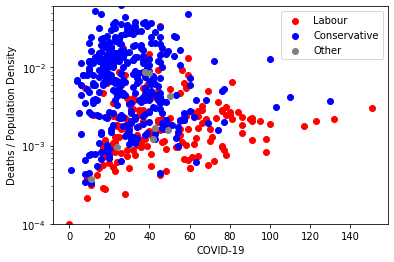

In [408]:
fig,ax=plt.subplots(1)

yname='Population Density'
yname='Percentage of the Population Non White'
yname='Total population: mid 2015 (excluding prisoners)'
yname='Deaths / Population Density'

ax.scatter(lab['COVID-19'],lab[yname],
               c='red',
               label='Labour')

ax.scatter(con['COVID-19'],con[yname],
               c='blue',
               label='Conservative')

ax.scatter(other['COVID-19'],other[yname],
               c='grey',
               label='Other')

ax.set_ylabel(yname)
ax.set_xlabel('COVID-19')

plt.legend();

ax.set_ylim(0.0001,0.06)
ax.set_yscale('log')

In [415]:
lab

COVID-19  All causes  \
PCON19CD                          
E14000537      64.0       168.0   
E14000540      56.0       148.0   
E14000541      24.0       142.0   
E14000542      32.0       205.0   
E14000548      30.0       169.0   
...             ...         ...   
E14001044      31.0       147.0   
E14001050      76.0       225.0   
E14001054      81.0       192.0   
E14001059      44.0       156.0   
E14001061      17.0       162.0   

           Total population: mid 2015 (excluding prisoners)       area  \
PCON19CD                                                                 
E14000537                                             91050   3.897658   
E14000540                                            134975   2.646558   
E14000541                                             87723   6.470941   
E14000542                                             94103  11.823600   
E14000548                                            109656   7.394342   
...                                                     ...        ...   
E14001044                                             69290   6.454557   
E14001050                                             91655   3.284196   
E14001054                                            101889   8.086956   
E14001059                                            108049   4.942215   
E14001061                                            133736   7.299565   

                                   n   q   r   a    u      e  ...  alliance  \
PCON19CD                                                      ...             
E14000537          Ashton-under-Lyne  -5   6  NW  UKD  68343  ...       0.0   
E14000540                    Barking   8  -9  LO  UKI  73977  ...       0.0   
E14000541           Barnsley Central  -2   6  YH  UKE  64534  ...       0.0   
E14000542              Barnsley East  -1   6  YH  UKE  69135  ...       0.0   
E14000548            Batley and Spen  -1   8  YH  UKE  78373  ...       0.0   
...                              ...  ..  ..  ..  ...    ...  ...       ...   
E14001044                Wirral West -11   2  NW  UKD  55377  ...       0.0   
E14001050   Wolverhampton South East  -6  -2  WM  UKG  62556  ...       0.0   
E14001054   Worsley and Eccles South  -8   5  NW  UKD  72177  ...       0.0   
E14001059  Wythenshawe and Sale East  -6   3  NW  UKD  75994  ...       0.0   
E14001061               York Central   0  11  YH  UKE  75351  ...       0.0   

            other  other_winner         mp_fullname majority_percent  \
PCON19CD                                                               
E14000537     0.0           0.0       Angela Rayner         0.110501   
E14000540     0.0           0.0      Margaret Hodge         0.346682   
E14000541   898.0           0.0       Daniel Jarvis         0.096767   
E14000542     0.0           0.0   Stephanie Peacock         0.084502   
E14000548  6432.0           0.0        Tracy Brabin         0.066601   
...           ...           ...                 ...              ...   
E14001044     0.0           0.0  Margaret Greenwood         0.069971   
E14001050     0.0           0.0        Pat McFadden         0.036929   
E14001054     0.0           0.0      Barbara Keeley         0.072002   
E14001059    58.0           0.0        Michael Kane         0.232266   
E14001061   691.0           0.0     Rachael Maskell         0.273609   

          majority_rank turnout_const turnout_reg  turnout_uk  turnout_2017  
PCON19CD                                                                     
E14000537         490.0      0.567522    0.656236    0.673108      0.604903  
E14000540         192.0      0.570844    0.674696    0.673108      0.619031  
E14000541         518.0      0.565329    0.643472    0.673108      0.608794  
E14000542         538.0      0.547738    0.643472    0.673108      0.589129  
E14000548         565.0      0.665263    0.643472    0.673108      0.670900  
...                 ...           ...         ...         ...           ...  
E14

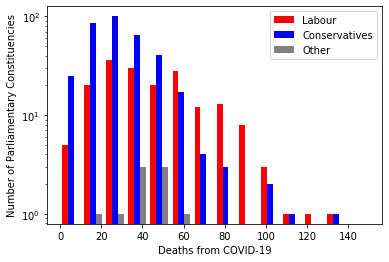

In [437]:
x=lab['COVID-19']
y=con['COVID-19']
z=other['COVID-19']

fig,ax=plt.subplots(1)

bins = np.linspace(0, 150, 15)

plt.hist([x, y, z], bins, color=['red','blue','grey'], label=['Labour', 'Conservatives','Other']);


ax.set_xlabel('Deaths from COVID-19')
ax.set_ylabel('Number of Parliamentary Constituencies')

ax.set_yscale('log')

plt.legend();


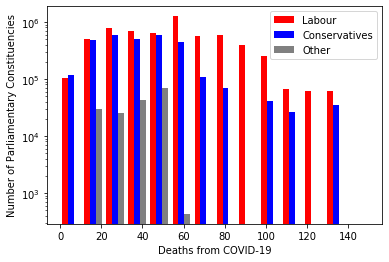

In [442]:
weight='Deaths / Population Density'

wx=lab[weight]
wy=con[weight]
wz=other[weight]

fig,ax=plt.subplots(1)

bins = np.linspace(0, 150, 15)

plt.hist([x, y, z], bins, weights=[wx,wy,wz], color=['red','blue','grey'], label=['Labour', 'Conservatives','Other']);


ax.set_xlabel('Deaths from COVID-19')
ax.set_ylabel('Number of Parliamentary Constituencies')

ax.set_yscale('log')

plt.legend();

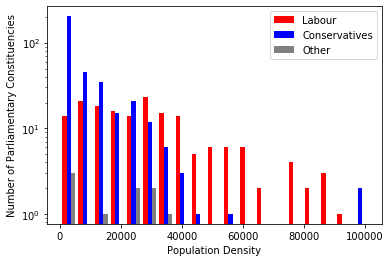

In [452]:
weight='Population Density'


value='Population Density'


x=lab[value]
y=con[value]
z=other[value]


wx=lab[weight]
wy=con[weight]
wz=other[weight]

fig,ax=plt.subplots(1)

bins = np.linspace(y.min(),y.max(), 20)

plt.hist([x, y, z], bins, color=['red','blue','grey'], label=['Labour', 'Conservatives','Other']);
#weights=[wx,wy,wz]

ax.set_xlabel('Population Density')
ax.set_ylabel('Number of Parliamentary Constituencies')

ax.set_yscale('log')

plt.legend();

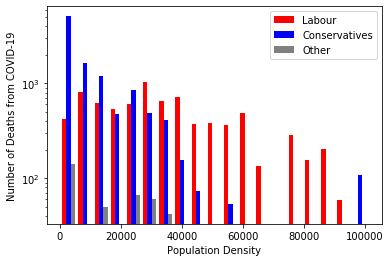

In [454]:
weight='COVID-19'

value='Population Density'


x=lab[value]
y=con[value]
z=other[value]


wx=lab[weight]
wy=con[weight]
wz=other[weight]

fig,ax=plt.subplots(1)

bins = np.linspace(y.min(),y.max(), 20)

plt.hist([x, y, z], bins, weights=[wx,wy,wz],color=['red','blue','grey'], label=['Labour', 'Conservatives','Other']);

ax.set_xlabel('Population Density')
ax.set_ylabel('Number of Deaths from COVID-19')

ax.set_yscale('log')

plt.legend();

In [461]:
df4.keys()

Index(['COVID-19', 'All causes',
       'Total population: mid 2015 (excluding prisoners)', 'area', 'n', 'q',
       'r', 'a', 'u', 'e', 'p', 'Population Density',
       'Deaths / Population Density', 'ConstituencyName', 'RegionID',
       'RegionName', 'CountryID', 'CountryName', 'DateThisUpdate',
       'DateOfDataset', 'PopTotalConstNum', 'PopWhiteConstNum',
       'PopMixedConstNum', 'PopAsianConstNum', 'PopBlackConstNum',
       'PopOtherConstNum', 'PopTotalConst%', 'PopWhiteConst%',
       'PopMixedConst%', 'PopAsianConst%', 'PopBlackConst%', 'PopOtherConst%',
       'PopTotalRegNum', 'PopWhiteRegNum', 'PopMixedRegNum', 'PopAsianRegNum',
       'PopBlackRegNum', 'PopOtherRegNum', 'PopTotalReg%', 'PopWhiteReg%',
       'PopMixedReg%', 'PopAsianReg%', 'PopBlackReg%', 'PopOtherReg%',
       'PopTotalUKNum', 'PopWhiteUKNum', 'PopMixedUKNum', 'PopAsianUKNum',
       'PopBlackUKNum', 'PopOtherUKNum', 'PopTotalUK%', 'PopWhiteUK%',
       'PopMixedUK%', 'PopAsianUK%', 'PopBlackUK%', 'Po

In [466]:
df4.sort_values('PopBlackConst%')[['n','PopBlackConst%','PopAsianConst%','PopWhiteConst%','PopTotalConst%']]

n  PopBlackConst%  PopAsianConst%  \
PCON19CD                                                                  
E14000575                  Blyth Valley        0.000572        0.006937   
E14001053                    Workington        0.000651        0.004658   
E14000877        Penrith and The Border        0.000672        0.004971   
E14000623                 Central Devon        0.000686        0.005139   
E14000677                     Easington        0.000701        0.006488   
...                                 ...             ...             ...   
E14000721  Hackney South and Shoreditch        0.268840        0.103667   
E14000687                      Edmonton        0.273142        0.129441   
E14000789            Lewisham, Deptford        0.288743        0.108414   
E14000655                 Croydon North        0.315479        0.233814   
E14000615        Camberwell and Peckham        0.373804        0.076086   

           PopWhiteConst%  PopTotalConst%  
PCON19CD                                   
E14000575        0.986577             1.0  
E14001053        0.989791             1.0  
E14000877        0.989680             1.0  
E14000623        0.985842             1.0  
E14000677        0.986964             1.0  
...                   ...             ...  
E14000721        0.513270             1.0  
E14000687        0.472626             1.0  
E14000789        0.498985             1.0  
E14000655        0.351680             1.0  
E14000615        0.448421             1.0  

[533 rows x 5 columns]

In [545]:
def classify_race(x):
    
    s=x.filter(regex='Const%',axis=0).drop(['PopTotalConst%','PopWhiteConst%']).astype('float64').idxmax()
    
    if x['PopWhiteConst%'] > 0.8: return 'PopWhiteConst%'
    
    return s 
    
    

In [554]:
df4['PopMax']=df4.apply(classify_race,axis=1)


white=df4[df4['PopMax']=='PopWhiteConst%']
black=df4[df4['PopMax']=='PopBlackConst%']
asian=df4[df4['PopMax']=='PopAsianConst%']




#df4.set_index('PopMax')
#df4.plot.bar('PopMax')

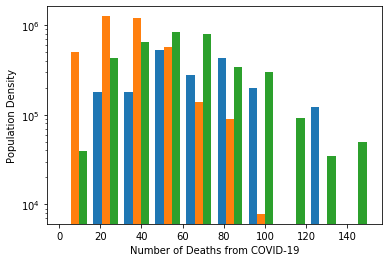

In [557]:
fig,ax=plt.subplots(1)

x='COVID-19'
y='Population Density'

ax.hist([black[x],white[x],asian[x]],weights=[black[y],white[y],asian[y]])

ax.set_xlabel('Number of Deaths from COVID-19')
ax.set_ylabel('Population Density')

ax.set_yscale('log')
